<a href="https://colab.research.google.com/github/sugiyama404/forecast_sp500/blob/main/cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM,GRU
from keras.layers import Conv1D, Input, MaxPool1D

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from google.colab import drive
import time

In [2]:
drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_train = '/content/drive/My Drive/' + nov_dir + 'sp500_train.csv'
nov_test = '/content/drive/My Drive/' + nov_dir + 'sp500_test.csv'

df_train = pd.read_csv(nov_train)
df_train['Date'] = pd.to_datetime(df_train['Date'], format = '%Y-%m-%d')
df_train['SP500'] = preprocessing.scale(df_train['SP500'])

print(df_train.shape)

look_back = 10
n_sample = len(df_train) - look_back
X, Y, A = [], [], []
for i in range(len(df_train) - look_back):
    X.append(df_train[['SP500']].iloc[i:(i+look_back)].values) # 観測データ
    Y.append(df_train[['SP500']].iloc[i+1:(i+look_back+1)].values) # 教師データ
    A.append(df_train[['SP500']].iloc[i+look_back].values) 
X_train = np.array(X)
y_train = np.array(Y)
A_train = np.array(A)

print(X_train.shape)
print(y_train.shape)


df_test = pd.read_csv(nov_test)
df_test['Date'] = pd.to_datetime(df_test['Date'], format = '%Y-%m-%d')
df_test['SP500'] = preprocessing.scale(df_test['SP500'])

print(df_test.shape)

look_back = 10
n_sample = len(df_test) - look_back
X, Y, A = [], [], []
for i in range(len(df_test) - look_back):
    X.append(df_test[['SP500']].iloc[i:(i+look_back)].values)
    Y.append(df_test[['SP500']].iloc[i+1:(i+look_back+1)].values)
    A.append(df_test[['SP500']].iloc[i+look_back].values)
X_test = np.array(X)
y_test = np.array(Y)
A_test = np.array(A)

print(X_test.shape)
print(y_test.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(628, 2)
(618, 10, 1)
(618, 10, 1)
(882, 2)
(872, 10, 1)
(872, 10, 1)


# ストップウォッチ関数

In [3]:
def stopwatch(end_time,start_time):
  elapsed_time = int(end_time - start_time)

  elapsed_hour = elapsed_time // 3600
  elapsed_minute = (elapsed_time % 3600) // 60
  elapsed_second = (elapsed_time % 3600 % 60)

  mozi = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)
  return mozi

# モデル構築

In [4]:
conv_filter = 4
units = 8
batch_size = 8

opt = Adam(learning_rate=0.001)

model = Sequential()

model.add(Conv1D(filters=conv_filter, kernel_size=1, padding="same", activation="tanh",batch_input_shape=(None, look_back, 1)))
model.add(MaxPool1D(pool_size=1, padding='same'))
model.add(Activation("relu"))
model.add(LSTM(units, return_sequences=True))
model.add(Dense(1, kernel_initializer='random_uniform'))
model.compile(loss = "mean_absolute_error", optimizer=opt)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 4)             8         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 4)             0         
_________________________________________________________________
activation (Activation)      (None, 10, 4)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 8)             416       
_________________________________________________________________
dense (Dense)                (None, 10, 1)             9         
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None


# 学習

In [5]:
epochs = 100

start_time = time.time()
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=0)
print("学習時間 LSTM : ", stopwatch(time.time(),start_time))

学習時間 LSTM :  00:01:43


# 損失関数

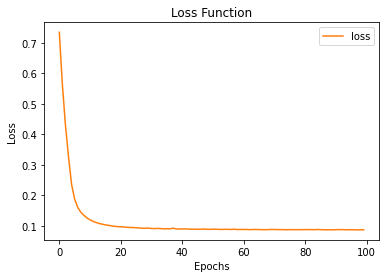

In [6]:
nov_dir2 = 'Colab Notebooks/workspace/export/'

loss = hist.history['loss']
epochs = len(loss)

plt.plot(range(epochs), loss, label="loss", color='tab:orange')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
nov_path2 = '/content/drive/My Drive/' + nov_dir2 + 'cnn_lstm_lossfunc.png'

plt.savefig(nov_path2)
plt.show()
plt.close('all')

# 訓練結果

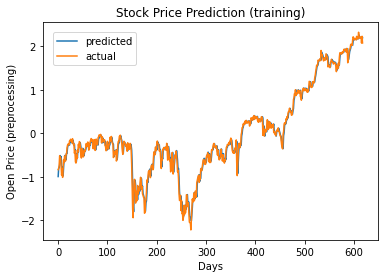

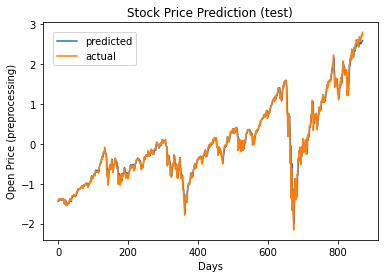

In [18]:
predicted = model.predict(X_train)
y1 = []
p = predicted.reshape(-1,10)
for i in range(len(p)):
    y1.append(p[i][-1])

x1 = [ i for i in range(len(y1))]

y2 = A_train
x2 = [ i for i in range(len(y2))]

plt.figure()
plt.plot(x1, y1, label="predicted")
plt.plot(x2, y2, label="actual")
plt.legend(borderaxespad=1)
plt.title('Stock Price Prediction (training)')
plt.xlabel('Days')
plt.ylabel('Open Price (preprocessing)')

nov_path3 = '/content/drive/My Drive/' + nov_dir2 + 'cnn_lstm_training.png'
plt.savefig(nov_path3)
plt.show()
plt.close('all')



predicted = model.predict(X_test)
y1 = []
p = predicted.reshape(-1,10)
for i in range(len(p)):
    y1.append(p[i][-1])

x1 = [ i for i in range(len(y1))]

y2 = A_test
x2 = [ i for i in range(len(y2))]

plt.figure()
plt.plot(x1, y1, label="predicted")
plt.plot(x2, y2, label="actual")
plt.legend(borderaxespad=1)
plt.title('Stock Price Prediction (test)')
plt.xlabel('Days')
plt.ylabel('Open Price (preprocessing)')

nov_path4 = '/content/drive/My Drive/' + nov_dir2 + 'cnn_lstm_test.png'
plt.savefig(nov_path4)
plt.show()
plt.close('all')

In [21]:
a = np.array([[[-0.55132077],[-0.82525816],[-0.95611004],[-0.78651904],[-0.52263131],
               [-0.64882191],[-0.76933434],[-0.80741747],[-0.89305029],[-1.02848967]]])
model.predict(a)

# a=np.array([[[-0.55132077]]]) の時 array([[[-1.0430841]]], dtype=float32)
# a[0][-1][0] = -1.02848967

array([[[-0.54819626],
        [-0.82622457],
        [-0.9370572 ],
        [-0.7571822 ],
        [-0.51334435],
        [-0.62922263],
        [-0.73636705],
        [-0.77258235],
        [-0.85829693],
        [-0.9923734 ]]], dtype=float32)